In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3, InceptionV3
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inc
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report, ConfusionMatrixDisplay
from sklearn.utils import class_weight

2025-04-03 23:30:41.541265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743733841.572395  144845 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743733841.581978  144845 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 23:30:41.607671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Libera a sessão atual
K.clear_session()

# Evita alocação total da memória da GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


W0000 00:00:1743733843.857189  144845 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.2. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1743733843.857350  144845 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.2. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1743733843.958245  144845 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.2. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1743733843.958378  144845 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.2. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1743733843.971344  144845 gpu_device.cc:2022] Created device

In [3]:
print("GPUs visíveis:", tf.config.list_physical_devices('GPU'))

GPUs visíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Configurações e caminhos

In [4]:
IMG_PATH = "/home/vitoroliveira/resized_train"
CSV_PATH = "/home/vitoroliveira/CNN_Rtinopatia_Diabetica/trainLabels3.csv"  # Certifique-se de ajustar o caminho se necessário
CHECKPOINT_PATH = '/home/vitoroliveira/CNN_Rtinopatia_Diabetica/model_checkpoint.weights.h5'
SAMPLE_FRAC = 1
BATCH_SIZE = 48
EPOCHS = 10
FINE_TUNE_EPOCHS = 20
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
#Carregando o CSV, amostrando e preparando os dados
df = pd.read_csv(CSV_PATH)
df = df.sample(frac=SAMPLE_FRAC, random_state=42)
df['Patient_ID'] = df['image'].apply(lambda x: x.split('_')[0])
df['path'] = df['image'].apply(lambda x: os.path.join(IMG_PATH, x))
df['exists'] = df['path'].map(lambda x: os.path.exists(x))

print(df['exists'].sum(), 'imagens encontradas de ', len(df), 'no total')
df['eye'] = df['image'].apply(lambda x: 1 if x.split('_')[-1].split('.')[0] == 'left' else 0)
from keras.utils import to_categorical
df['level_cat'] = df['level'].map(lambda x: to_categorical(x, 1+df['level'].max()))

df.dropna(inplace=True)
df = df[df['exists']]
df.sample(5)

35107 imagens encontradas de  35107 no total


,image,level,width,height,center_row,center_col,radius,Patient_ID,path,exists,eye,level_cat
22377,28230_right.jpeg,2,1024,683,341,513,425,28230,/home/vitoroliveira/resized_train/28230_right....,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
13142,16530_left.jpeg,0,1024,683,352,508,323,16530,/home/vitoroliveira/resized_train/16530_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
9004,11299_right.jpeg,0,1024,683,349,507,318,11299,/home/vitoroliveira/resized_train/11299_right....,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
10239,12907_left.jpeg,0,1024,683,346,514,318,12907,/home/vitoroliveira/resized_train/12907_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
26369,33390_left.jpeg,0,1024,683,332,513,414,33390,/home/vitoroliveira/resized_train/33390_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

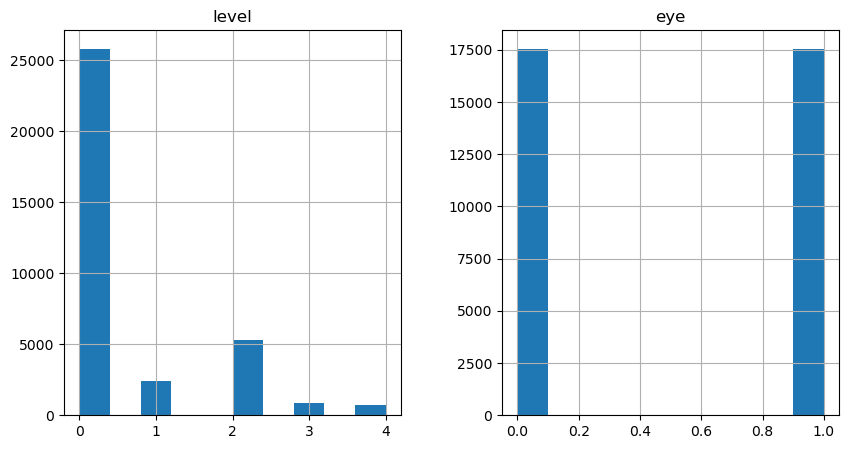

In [6]:
df[['level', 'eye']].hist(figsize = (10, 5))

Dividindo os dados em treino e teste

In [7]:
rr_df = df[['Patient_ID', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['Patient_ID'], test_size=0.25, random_state=42, stratify=rr_df['level'])
train_df = df[df['Patient_ID'].isin(train_ids)]
valid_df = df[df['Patient_ID'].isin(valid_ids)]
print('Train:', len(train_df), 'Valid:', len(valid_df))

Train: 27146 Valid: 9589


Gerando os dados de treino e validação

In [8]:
train_df['level'] = train_df['level'].astype(str)
valid_df['level'] = valid_df['level'].astype(str)

#EfficientNetB3

train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_eff,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    
)

valid_datagen_eff = ImageDataGenerator(preprocessing_function=preprocess_eff, rescale=1./255)

train_generator_eff = train_datagen_eff.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='level',
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
)

valid_generator_eff = valid_datagen_eff.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='level',
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

# InceptionV3

train_datagen_inc = ImageDataGenerator(
    preprocessing_function=preprocess_inc,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

valid_datagen_inc = ImageDataGenerator(preprocessing_function=preprocess_inc, rescale=1./255)

train_generator_inc = train_datagen_inc.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='level',
    target_size=(299, 299),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
)

valid_generator_inc = valid_datagen_inc.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='level',
    target_size=(299, 299),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)


/tmp/ipykernel_144845/4123197679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['level'] = train_df['level'].astype(str)
/tmp/ipykernel_144845/4123197679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['level'] = valid_df['level'].astype(str)


Found 27146 validated image filenames belonging to 5 classes.
Found 9589 validated image filenames belonging to 5 classes.
Found 27146 validated image filenames belonging to 5 classes.
Found 9589 validated image filenames belonging to 5 classes.


Função de perda focal_loss para lidar com o desbalanceamento de classes

In [9]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps =  1e-7
        y_pred = K.clip(y_pred, eps, 1 - eps)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

Construindo e compilando modelos

In [10]:
# EfficientNetB3

input_b3 = tf.keras.Input(shape=(300, 300, 3))
base_model_b3 = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=input_b3)

x_b3 = base_model_b3.output
x_b3 = GlobalAveragePooling2D()(x_b3)
x_b3 = Dropout(0.2)(x_b3)

predictions_b3 = Dense(5, activation='softmax')(x_b3)

model_b3 = Model(inputs=base_model_b3.input, outputs=predictions_b3)

for layer in base_model_b3.layers:
    layer.trainable = False
    
model_b3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=focal_loss(),
    metrics=['accuracy']
)

model_b3.summary()
    

2025-04-03 23:30:48.082741: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_NO_BINARY_FOR_GPU'

2025-04-03 23:30:48.082771: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2025-04-03 23:30:48.082783: W tensorflow/core/framework/op_kernel.cc:1829] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
2025-04-03 23:30:48.082794: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'


InternalError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:Cast] name: 